In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrix
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
    pred_values = model.predict_proba(data)[:,1]
    bins=np.array([0,cutoff,1])
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    accuracy = 100*(cm[0,0]+cm[1,1])/cm.sum()
    fnr = 100*(cm[1,0])/(cm[1,0]+cm[1,1])
    precision = 100*(cm[1,1])/(cm[0,1]+cm[1,1])
    recall = 100 - fnr 
    print("Accuracy = ", accuracy)
    print("FNR = ", fnr)
    print("Precision = ", precision)
    print("Recall = ", recall)
    print("Confusion matrix = \n", cm_df)
    return (" ")
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
def plot_roc_curve(fpr, tpr, label = None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0, 1, 0.05), rotation = 90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

In [3]:
data = pd.read_csv("mushrooms.csv")

In [4]:
#transform all predictors into dummy variables 
#1 = poisonious, 0 = edible 
X = pd.get_dummies(data, prefix_sep = '', columns = data.columns.drop('class')).drop(['class'], axis = 1)
y = np.where(data["class"] == "e", 0, 1)

In [5]:
X = pd.get_dummies(data.drop(columns=['class']))
y = np.where(data["class"] == "e", 0, 1)

In [6]:
#splitting data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 1)

In [7]:
X_train

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
6992,0,0,0,1,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
616,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2623,0,0,1,0,0,0,1,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2772,0,0,0,0,0,1,0,0,0,1,...,0,1,0,1,0,0,0,0,0,0
976,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7935,0,0,0,1,0,0,0,0,0,1,...,0,1,0,1,0,0,0,0,0,0
5192,0,0,0,0,0,1,0,0,0,1,...,0,1,0,1,0,0,0,0,0,0
3980,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,1,0,0,0,0,0
235,0,0,0,0,0,1,1,0,0,0,...,0,1,0,1,0,0,0,0,0,0


In [8]:
logreg = LogisticRegression(random_state=1)
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
print("Accuracy:",logreg.score(X_test, y_test))

Accuracy: 0.9988810145468109


In [9]:
# Standardizing data
scaler = StandardScaler()
scaler.fit(X)
Xtrain_std = scaler.transform(X_train)

In [10]:
param_grid = {
    'penalty' : ['l1','l2']
}
skf = StratifiedKFold(n_splits = 5)
grid_search = GridSearchCV(LogisticRegression(random_state = 1), param_grid, 
                           scoring = ['precision', 'accuracy', 'recall'], refit = "recall", 
                           cv = skf, n_jobs = -1, verbose = True)
grid_search.fit(X_train, y_train)
print('Best params for recall')
print(grid_search.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best params for recall
{'penalty': 'l2'}


In [12]:
logreg = LogisticRegression(random_state=1, penalty='l2', n_jobs=-1, max_iter=1000)
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
print("Accuracy:",logreg.score(X_test, y_test))

Accuracy: 0.9988810145468109


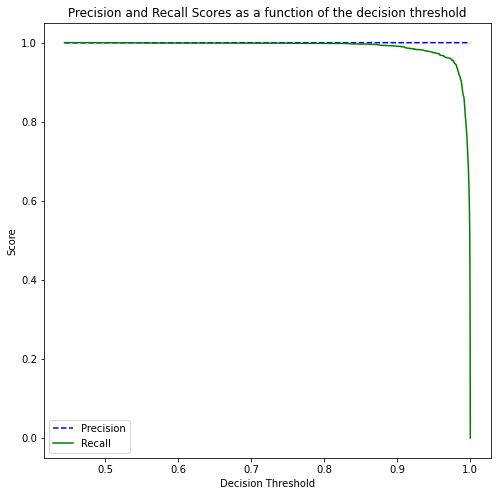

In [13]:
ypred = logreg.predict_proba(X_train)[:, 1]
p, r, thresholds = precision_recall_curve(y_train, ypred)
plot_precision_recall_vs_threshold(p, r, thresholds)

In [14]:
confusion_matrix_data(X_test, y_test, logreg, 0.8)

Accuracy =  99.70160387914957
FNR =  0.60790273556231
Precision =  100.0
Recall =  99.3920972644377
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       1365.0          0.0
Actual 1          8.0       1308.0


' '